In [1]:
from keras.models import load_model
from utils import *

# Loading CapsPhse Model
model = load_model('./Model/CapsPhase_CNNX.h5', custom_objects={'PrimaryCap': PrimaryCap,
                                                 'CapsuleLayer':CapsuleLayer,
                                                  'Length':Length,
                                                   'margin_loss':margin_loss})


Using TensorFlow backend.
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [2]:
import numpy as np
import obspy
from scipy import ndimage,misc
import matplotlib.pyplot as plt
from obspy.core import read
import pylab
import numpy as np
import glob
from obspy.signal.trigger import trigger_onset
import glob 
import numpy as np
import os

n_shift = 10 # Number of samples to shift the sliding window at a time
# only valid for 100 Hz sampling rate.
batch_size = 512
dt = 0.01
half_dur = 2.00
only_dt = 0.01
n_win = int(half_dur/only_dt)
n_feat = 2*n_win

def CapsPhase(st,fremin,fremax,fo,fs,threp,thres,plotFlag):
        
    #---------------------------Input--------------------------
    #fremin ---- min corner frequency for the bandpass filter. 
    #fremax ---- max corner frequency for the bandpass filter. 
    #fo     ---- filter order. 
    #fs     ---- Sampling Rate, only valid for 100 Hz.
    #threp  ---- output P threshold.
    #thres  ---- output S threshold.
    #plotFlag --- True if you want to plot the CapsPhase output.
    #---------------------------Output--------------------------
    #pwave      ----- Sample index of P wave arrival time.
    #swave      ----- Sample index of S wave arrival time.
    #pwavetime  ----- P arriva time.
    #wavetime   ----- S arriva time.

    st1 = st.copy()
    #st1 = st1.filter(type='bandpass', freqmin=1, freqmax=40)
    #st1 = st1.filter("highpass", freq=1.0)

    # band-bass filter
    st1[0].data = butter_bandpass_filter_zi(st1[0].data, fremin, fremax, fs, order=fo)
    st1[1].data = butter_bandpass_filter_zi(st1[1].data, fremin, fremax, fs, order=fo)
    st1[2].data = butter_bandpass_filter_zi(st1[2].data, fremin, fremax, fs, order=fo)

    # Preparing the sliding windows
    sliding_N = sliding_window(st1[0].data, n_feat, stepsize=n_shift)
    sliding_E = sliding_window(st1[1].data, n_feat, stepsize=n_shift)
    sliding_Z = sliding_window(st1[2].data, n_feat, stepsize=n_shift)
    #print(n_feat,n_shift,np.shape(sliding_Z))
    tr_win = np.zeros((sliding_N.shape[0], n_feat, 3))
    tr_win[:,:,0] = sliding_E
    tr_win[:,:,1] = sliding_N
    tr_win[:,:,2] = sliding_Z
    tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None]
    tr_win = np.reshape(tr_win, (np.shape(tr_win)[0], np.shape(tr_win)[1], np.shape(tr_win)[2]))
    ts = model.predict(tr_win, verbose=0, batch_size=512)

    # Median Filter for Smoothing
    prob_P = ts[:,0]
    prob_S = ts[:,1]
    ascent = misc.ascent()
    prob_P = ndimage.median_filter(prob_P, size=2)
    prob_S = ndimage.median_filter(prob_S, size=2)
    
    # If you want to plot the output of CapsPhase
    if plotFlag == True:
        plotfn(prob_P,prob_S)
    
    # Median filter for smoothing
    ascent = misc.ascent()
    prob_P = ndimage.median_filter(prob_P, size=2)
    prob_S = ndimage.median_filter(prob_S, size=2)

    p_picks = []
    s_picks = []
    pickp=[]
    picks=[]
    
    
    # In case you divided the stream into smaller non-overlapped windows, it is better to use this trigger option.
    '''
    # P trigger.
    trigp = trigger_onset(prob_P, thre, 0.1)
    if len(trigp)>0:
        pickp = np.argmax(prob_P)
    # S trigger.
    trigs = trigger_onset(prob_S, thre, 0.1)
    if len(trigs)>0:
        picks = np.argmax(prob_S)
        
    pwave = int(pickp*n_shift+200)
    pwavetime = st[0].stats.starttime + pwave/fs    
    
    swave = int(picks*n_shift+200)
    swavetime = st[0].stats.starttime + swave/fs    
    '''
    
    
     
    # P trigger.
    trigp = trigger_onset(prob_P, threp, 0.1)
    #if len(trigs)>0:
    for trig in trigp:
        if trig[1] == trig[0]:
            continue
        else:
            pickpeak = np.argmax(prob_P[trig[0]:trig[1]])+trig[0]
            pickp.append(pickpeak)
    # S trigger.        
    trigs = trigger_onset(prob_S, thres, 0.1)
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        else:
            pickpeak = np.argmax(prob_S[trig[0]:trig[1]])+trig[0]
            picks.append(pickpeak)
                
    
    
    pwave=[]
    swave=[]
    pwavetime=[]
    swavetime=[]
    for gp in pickp:
        pwave.append(int(gp*n_shift+200))
        pwavetime.append(st[0].stats.starttime + int(gp*n_shift+200)/fs)
    for gs in picks:
        swave.append(int(gs*n_shift+200))
        swavetime.append(st[0].stats.starttime + int(gs*n_shift+200)/fs)
    
    
    return pwave,swave, pwavetime, swavetime

./Data_Test\Test0.MSEED


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


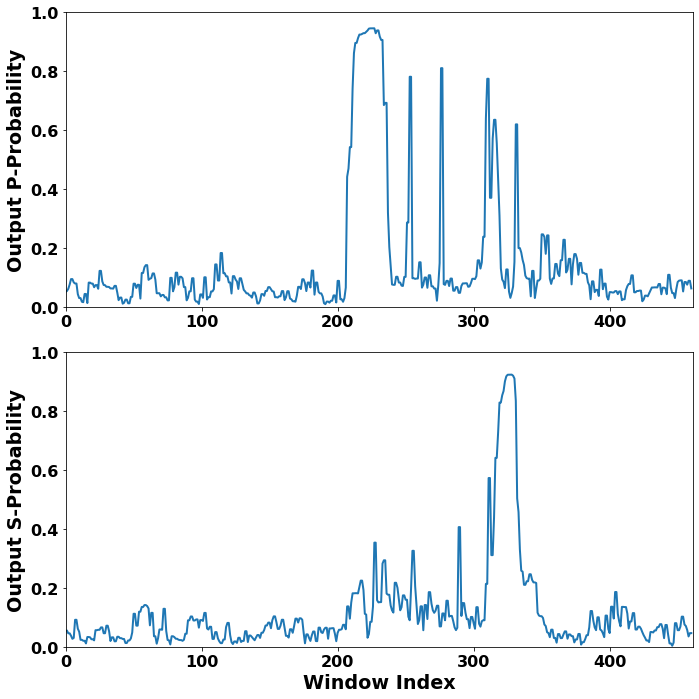

./Data_Test\Test1.MSEED


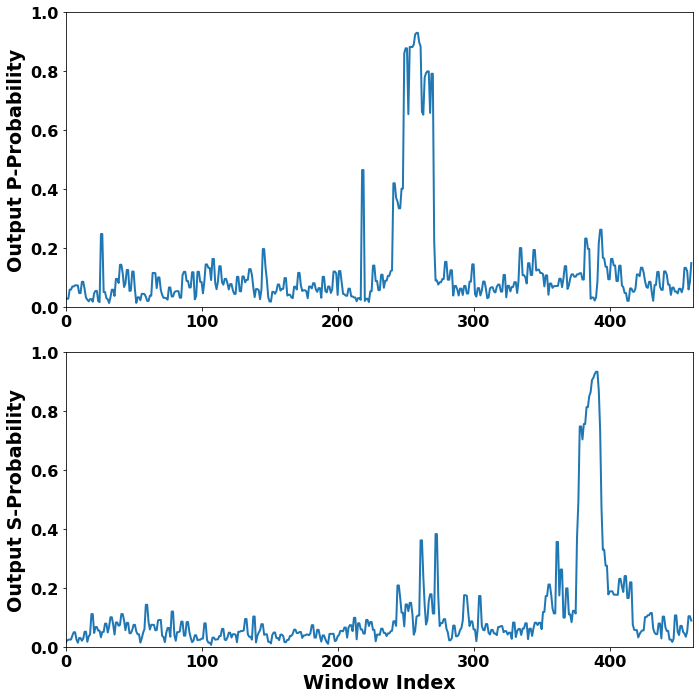

./Data_Test\Test7.MSEED


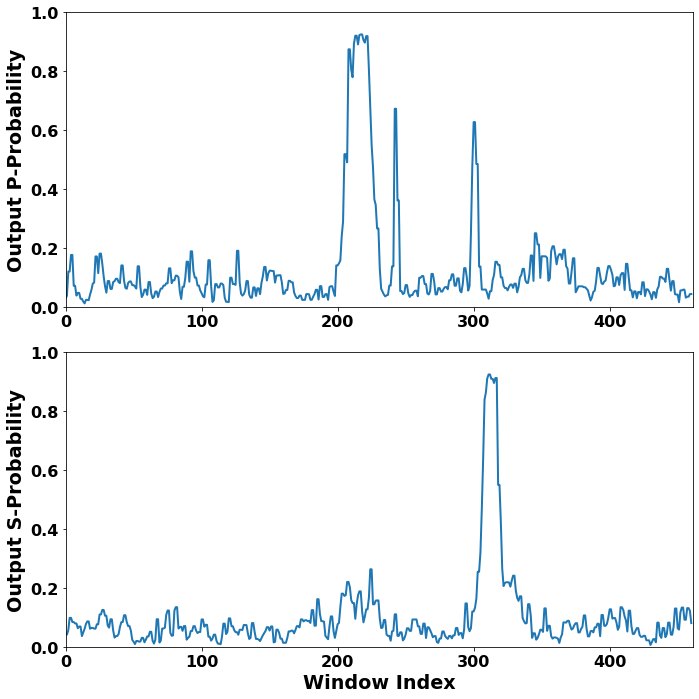

./Data_Test\Test10.MSEED


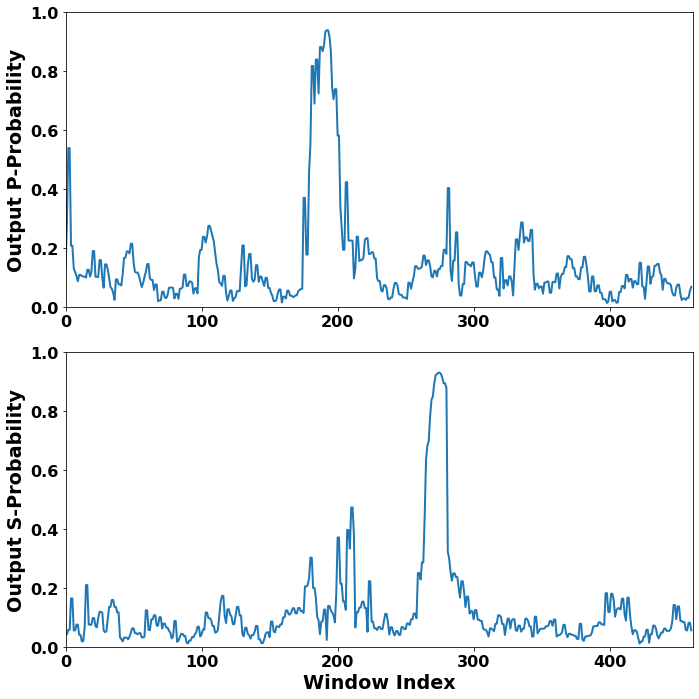

./Data_Test\Test12.MSEED


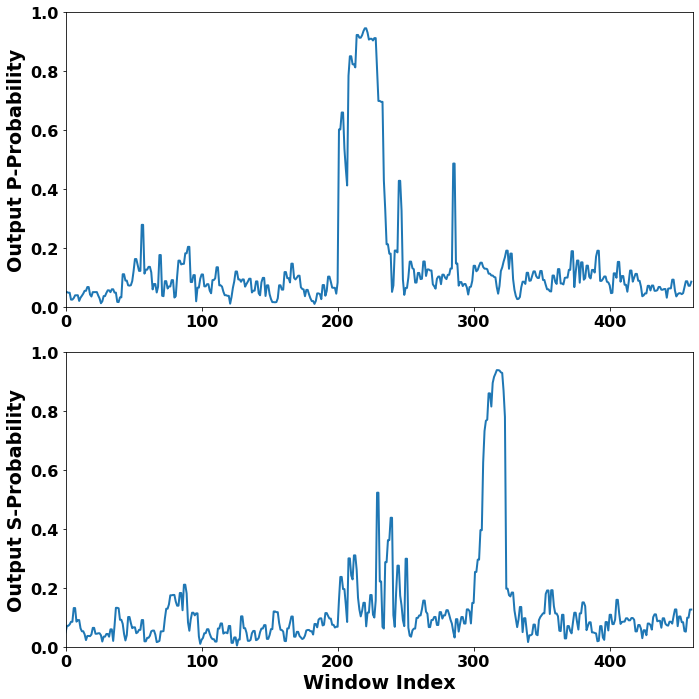

./Data_Test\Test13.MSEED


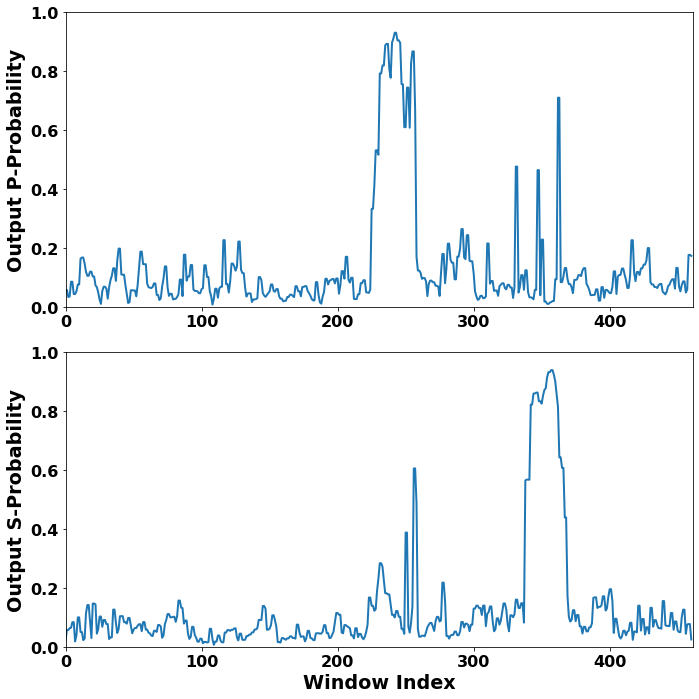

./Data_Test\Test15.MSEED


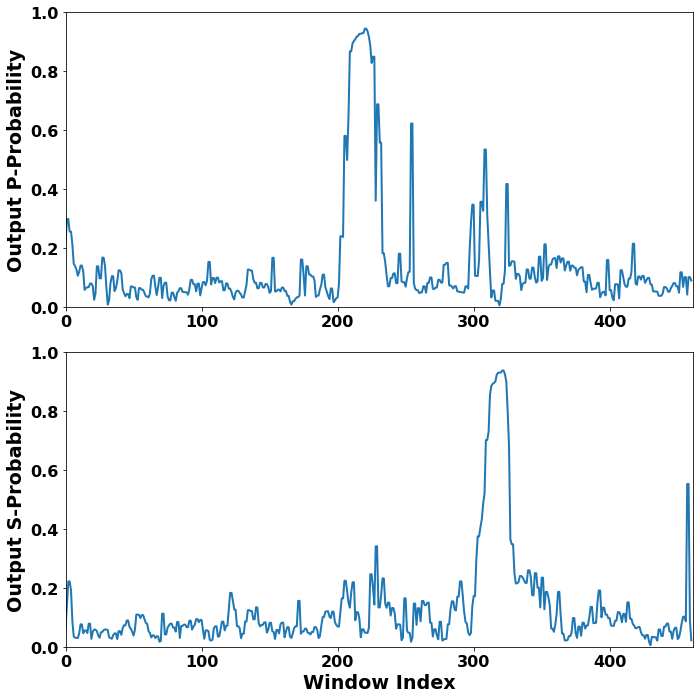

./Data_Test\Test16.MSEED


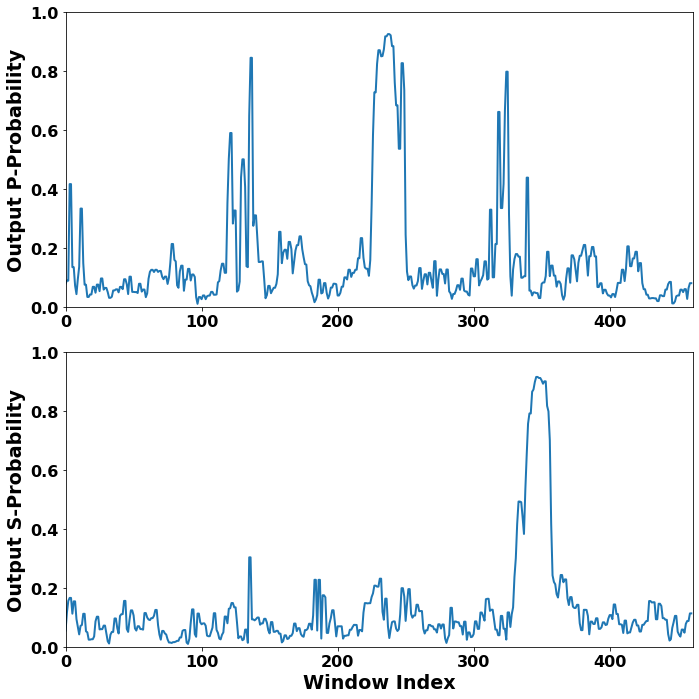

./Data_Test\Test18.MSEED


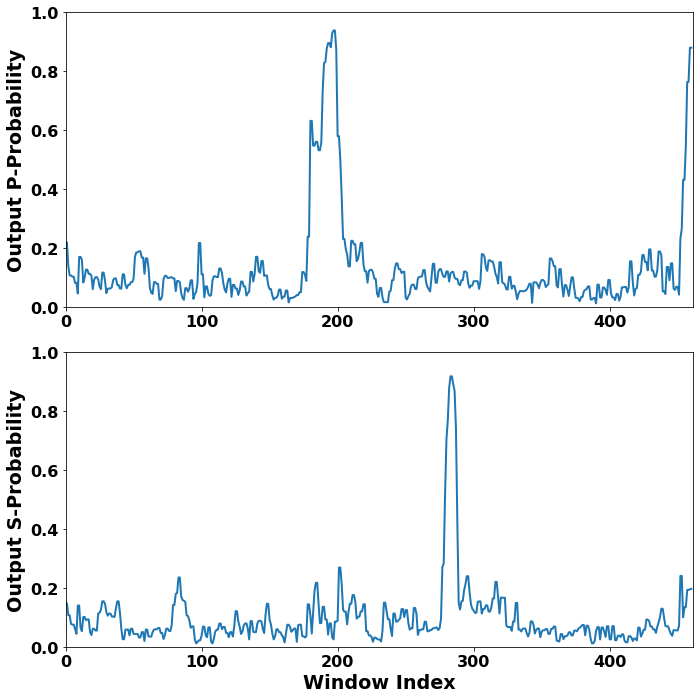

./Data_Test\Test21.MSEED


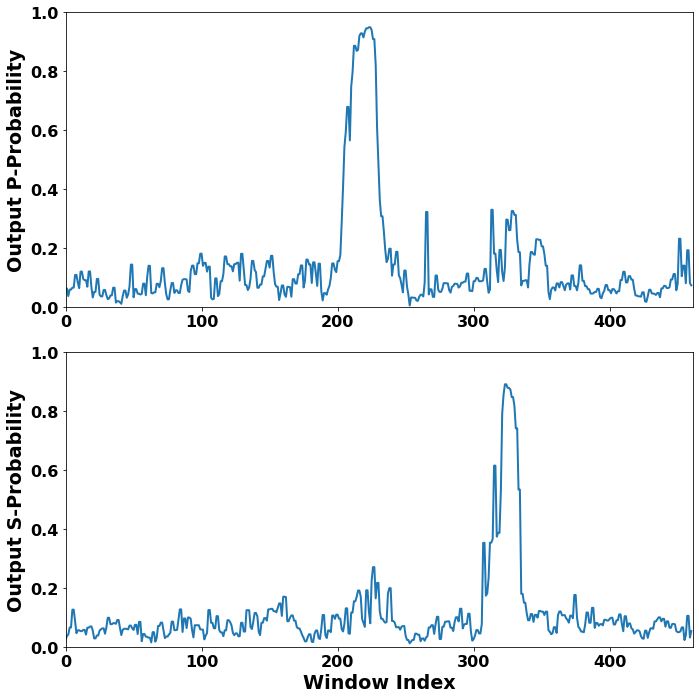

In [3]:
#---------------------------Input--------------------------
#fremin ---- min corner frequency for the bandpass filter. 
#fremax ---- max corner frequency for the bandpass filter. 
#fo     ---- filter order. 
#fs     ---- Sampling Rate, only valid for 100 Hz.
#threp  ---- output P threshold.
#thres  ---- output S threshold.
#plotFlag --- True if you want to plot the CapsPhase output.
#---------------------------Output--------------------------
#pwave      ----- Sample index of P wave arrival time.
#swave      ----- Sample index of S wave arrival time.
#pwavetime  ----- P arriva time.
#wavetime   ----- S arriva time.


#-------------------------------------Note------------------------------------------------------
# The program takes any input size and applies CapsPhase in one shot. However, you can divide 
# the data into small non-overlapping windows, e.g., 60 second for each window, and obtain the 
# output label for each window.
#-----------------------------------------------------------------------------------------------

plotFlag = True
# Default Values, You can change to adapt your data.
fremin  = 1
fremax  = 40
fo      = 5
fs      = 100  #You need to upsample/downsample if the sampling rate is not 100Hz.
threp    = 0.9 #You can decrese this value if the SNR is high, and increse if the SNR is low.
thres    = 0.8
# Note that you can activate the median filter if the CapsPhase output is not smooth.

# Load data Path
DataPath = sorted(glob.glob('./Data_Test/Te*'),key=os.path.getmtime)
swavetimeall=[]
pwavetimeall=[]
pwaveall=[]
swaveall=[]
for i in DataPath:
    print(i)
    # Read the data
    st = obspy.read(i)
    #-------------------------------------Start The main Program-----------------------------------------------
    # Apply CapsPhase 
    pwave,swave,pwavetime,swavetime = CapsPhase(st,fremin,fremax,fo,fs,threp,thres,plotFlag)
    #--------------------------------------End The main Program------------------------------------------------
    # Save the detected phase times.
    pwaveall.append(pwave)
    swaveall.append(swave)
    pwavetimeall.append(pwavetime)
    swavetimeall.append(swavetime)

In [8]:
# Check the P and S errors.
PWave = np.load(r'./Labels/PWaveall.npy')
SWave = np.load(r'./Labels/SWaveall.npy')
PWaveTime = np.load(r'./Labels/PWaveTime.npy', allow_pickle=True)
SWaveTime = np.load(r'./Labels/SWaveTime.npy', allow_pickle=True)


pwaveall = np.array(pwaveall)
pwaveall = np.reshape(pwaveall,(pwaveall.shape[0]*pwaveall.shape[1]))

pwavetimeall = np.array(pwavetimeall)
pwavetimeall = np.reshape(pwavetimeall,(pwavetimeall.shape[0]*pwavetimeall.shape[1]))

swaveall = np.array(swaveall)
swaveall = np.reshape(swaveall,(swaveall.shape[0]*swaveall.shape[1]))

swavetimeall = np.array(swavetimeall)
swavetimeall = np.reshape(swavetimeall,(swavetimeall.shape[0]*swavetimeall.shape[1]))

print('The P arrival time error is ', PWaveTime- pwavetimeall, 'second' )
print('The S arrival time error is ', SWaveTime- swavetimeall, 'second' )
print('The P arrival time error is ', np.abs(PWave- pwaveall), 'samples' )
print('The S arrival time error is ', np.abs(SWave- swaveall), 'samples' )



The P arrival time error is  [-0.02 0.12 -0.01 -0.02 -0.04 -0.01 0.04 0.02 -0.08 -0.01] second
The S arrival time error is  [-0.25 -0.16 -0.05 -0.1 0.02 -0.05 -0.08 0.12 -0.02 0.11] second
The P arrival time error is  [  2.  12.   1.   2.   4.   1.   4.   2.   8.   1.] samples
The S arrival time error is  [ 25.  16.   5.  10.   2.   5.   8.  12.   2.  11.] samples
